# Sentiment Analysis in Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk


In [2]:
df=pd.read_csv('../data/Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


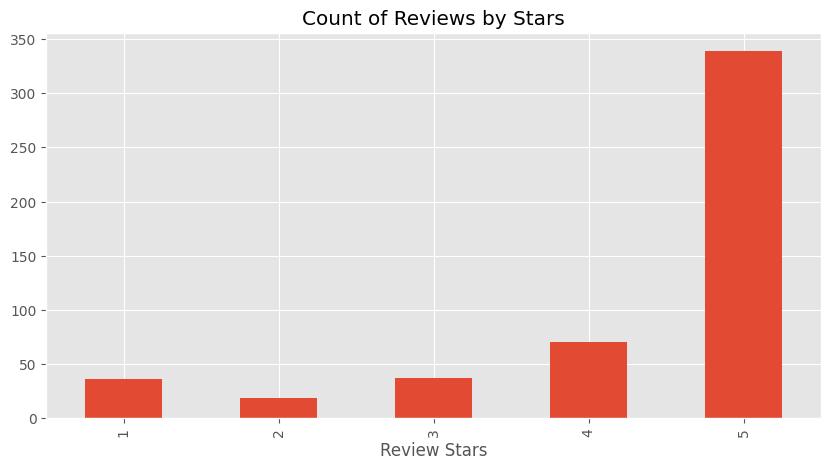

In [3]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## basic nltk

In [4]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [5]:
tokens=nltk.word_tokenize(example)
tokens[:10]


['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [6]:
tagged=nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [7]:
entities=nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia=SentimentIntensityAnalyzer()


In [9]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [10]:
# running the polarity score on the entire dataset
res={}
for i, row in tqdm(df.iterrows(),total=len(df)):
    text=row['Text']
    myid=row['Id']
    res[myid]=sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
vaders=pd.DataFrame(res).T
vaders=vaders.reset_index().rename(columns={'index':'Id'})
vaders=vaders.merge(df,how='left')

In [12]:
# we have sentiment scores and metadata
vaders.head()


,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plotting Vader results

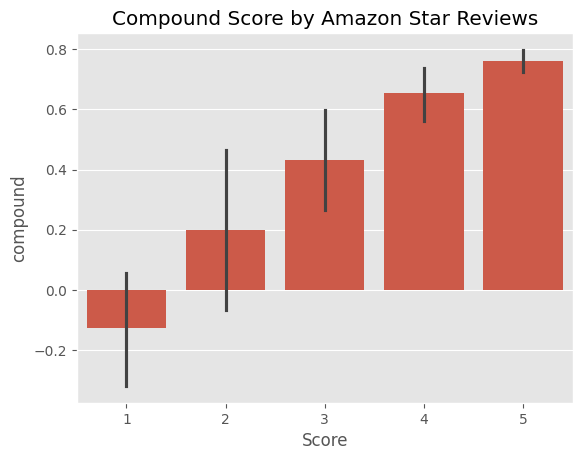

In [13]:
ax=sns.barplot(data=vaders,x='Score',y='compound')
ax.set_title('Compound Score by Amazon Star Reviews')
plt.show()

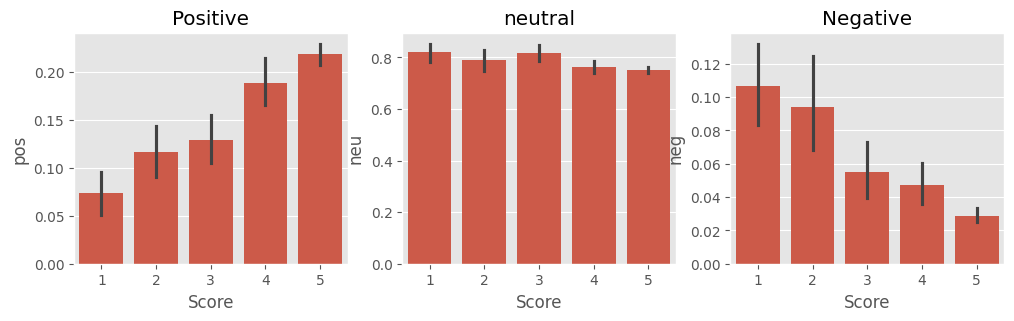

In [14]:
fig,axs=plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=vaders,x='Score',y='pos',ax=axs[0])
sns.barplot(data=vaders,x='Score',y='neu',ax=axs[1])
sns.barplot(data=vaders,x='Score',y='neg',ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('neutral')
axs[2].set_title('Negative')
plt.show()


# Step 3. Roberta pretrained model
  

In [15]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [16]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

### Vader result example

In [17]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

### Run for Roberta model

In [18]:
encoded_text=tokenizer(example, return_tensors='pt')
output=model(**encoded_text)
scores=output[0][0].detach().numpy()
scores=softmax(scores)
scores_dict={
    'roberta_neg':scores[0],
    'roberta_neu':scores[1],
    'roberta_pos':scores[2]
}

scores_dict


{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687453,
 'roberta_pos': 0.0029573678}

In [19]:
def polarityScoresRoberta(example):
    encoded_text=tokenizer(example, return_tensors='pt')
    output=model(**encoded_text)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2]
    }
    return scores_dict

In [20]:
res={}
for i,row in tqdm(df.iterrows(),total=len(df)):
    try:
        text=row['Text']
        myId=row['Id']
        vaderResults=sia.polarity_scores(text)
        vaderResultsRename={}
        for key,value in vaderResults.items():
            vaderResultsRename[f'vader_{key}'] = value

        robertaResults=polarityScoresRoberta(text)
        both={**vaderResultsRename,**robertaResults}
        res[myId]=both
    except RuntimeError:
        print(f'Broke for id {myId}')


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [21]:
resultsDf=pd.DataFrame(res).T
resultsDf=resultsDf.reset_index().rename(columns={'index':'Id'})
resultsDf=resultsDf.merge(df,how='left')

In [22]:
resultsDf.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
